# DSC180B EDA

# Importing Packages

In [22]:
import json
from src.data import make_dataset
from src.features import build_features

In [23]:
from qiime2.plugins import feature_table
from qiime2 import Artifact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import biom
import seaborn as sns

## Loading Data

In [24]:
## Obtaining file paths
with open("config/data-params.json") as fh:
    file_paths = json.load(fh)

In [25]:
table = make_dataset.read_feature_table(file_paths["feature_table_path"])
metadata = make_dataset.read_metadata(file_paths["metadata_path"])

/Users/amando/Desktop/DSC180-Q2-Project/src/data/make_dataset.py:25: DtypeWarning: Columns (1,2,3,4,6,7,8,10,11,12,13,14,17,18,19,20,25,26,27,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,55,56,57,61,62,63,64,65,66,67,69,70,71,72,73,75,76,78,80,82,83,84,85,86,87,88,89,90,91,92,95,98,99,102,103,104,105,106,107,108,109,111,119,121,122,123,124,125,126,127,128,129,130,131,132,133,134,136,138,139,141,142,143,144,145,146,147,148,152,153,155,156,157,160,164,165,168,169,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(path, sep='\t', index_col=0)


In [26]:
biom_table = table.view(biom.Table)
print(biom_table.head())

# Constructed from biom file
#OTU ID	11666.BLANK7.7B	11666.BLANK5.5B	11666.G0341A	11666.BLANK3.3A	11666.BLANK5.5E
AACATAAGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGCCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAAACACTGGGCGTAAAGGGCGCGTAGGCGGTCTGTTAAGTCGGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCATAAAGGGCGCGTAGGTGGTTTGTTAAGTCAGATGTGAAATGTAGGGGCTCAACCCCTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGAGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0


In [27]:
metadata.head()

,abdominal_obesity_idf_v2,abdominal_obesity_ncep_v2,ac_ratio_gt30,ac_ratio_gt30_v2,age_units,age_v2,agegroup_c6_nhanes_v2,agegroup_c6_v2,anonymized_name,antibiotic,...,taxon_id,title,type_stool,us_born_v2,weight_norm_overall_v2,weight_units,yes_no,yogurt,yrs_btwn_viv2,yrsus_c2_v2
sample_name,,,,,,,,,,,,,,,,,,,,,
11666.BLANK1.1A,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1A.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1A.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1B.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1B.ITS,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable
11666.BLANK1.1C,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,BLANK1.1C,not applicable,...,256318.0,GOLD study,not applicable,not applicable,not applicable,not applicable,NaN,not applicable,not applicable,not applicable


## Missing Data Analysis

In [28]:
# Function for single representation of missing values
def missing_values(col, type='categorical'):
    temp = col.apply(lambda x: np.nan if x == 'not applicable' or x == 'not provided' else x)
    if type == 'numeric':
        temp = temp.apply(lambda x: x if pd.isnull(x) else np.float64(x))
    return temp

In [29]:
# Subset of data
disease_cols = ['abdominal_obesity_ncep_v2', 'ckd_v2', 'diabetes2_v2','hypertension2_v2','precvd_v2','elevated_bp_selfmeds_v2','dyslipidemia_v2']
features = disease_cols + ['gender_v2','agegroup_c6_v2','bmigrp_c6_v2','center','us_born_v2','income_c5_v2']

In [30]:
metadata['ckd_v2'].value_counts()

1                 1746
2                 1189
not applicable     596
3                  167
2.0                 17
4                   14
1.0                  8
5                    7
not provided         7
Name: ckd_v2, dtype: int64

In [31]:
missing_values(metadata['ckd_v2'],'numeric').value_counts()

1.0    1754
2.0    1206
3.0     167
4.0      14
5.0       7
Name: ckd_v2, dtype: int64

# Subset of Metadata

In [32]:
sub_metadata = metadata[features]
sub_metadata.head()

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.BLANK1.1A,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1A.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1B,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1B.ITS,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable
11666.BLANK1.1C,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable


In [33]:
numeric_col = [
    'abdominal_obesity_ncep_v2','ckd_v2','diabetes2_v2',
    'hypertension2_v2','precvd_v2','elevated_bp_selfmeds_v2',
    'dyslipidemia_v2','agegroup_c6_v2',
    'bmigrp_c6_v2','us_born_v2','income_c5_v2']
categorical_col = ['center','gender_v2']

## Defining missing values

In [34]:
sub_metadata.loc[:,numeric_col] = sub_metadata.loc[:,numeric_col].apply(lambda x: missing_values(x,'numeric'))
sub_metadata.loc[:,categorical_col] = sub_metadata.loc[:,categorical_col].apply(lambda x: missing_values(x,'categorical'))

/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_15332/289276134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.loc[:,numeric_col] = sub_metadata.loc[:,numeric_col].apply(lambda x: missing_values(x,'numeric'))
/var/folders/0n/ts4w12h13klbffn_h351p4f80000gn/T/ipykernel_15332/289276134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_metadata.loc[:,categorical_col] = sub_metadata.loc[:,categorical_col].apply(lambda x: missing_values(x,'categorical'))


In [70]:
sub_metadata.head()

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.BLANK1.1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11666.BLANK1.1A.ITS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11666.BLANK1.1B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11666.BLANK1.1B.ITS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11666.BLANK1.1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA on Subset of Metadata

### Disease Counts

In [35]:
def create_bar_col_binary(df, col_name):
    ax = df[col_name].dropna().value_counts().sort_index(ascending=False).plot(kind='barh')
    ax.set_xlabel('count')
    ax.set_ylabel('outcome')
    ax.set_title(col_name)

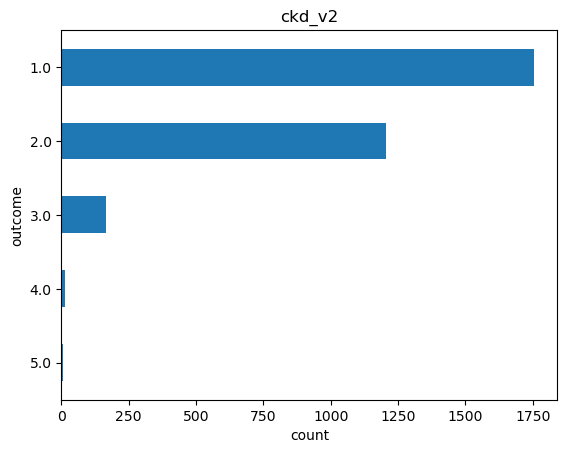

In [36]:
create_bar_col_binary(sub_metadata, 'ckd_v2')

### Gender Counts

<AxesSubplot:>

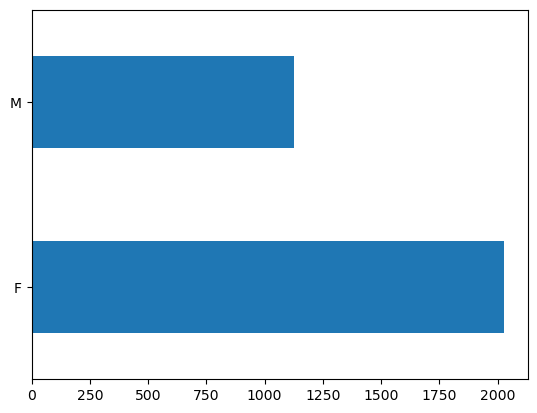

In [37]:
sub_metadata['gender_v2'].dropna().value_counts().plot(kind='barh')

### Center Counts

<AxesSubplot:>

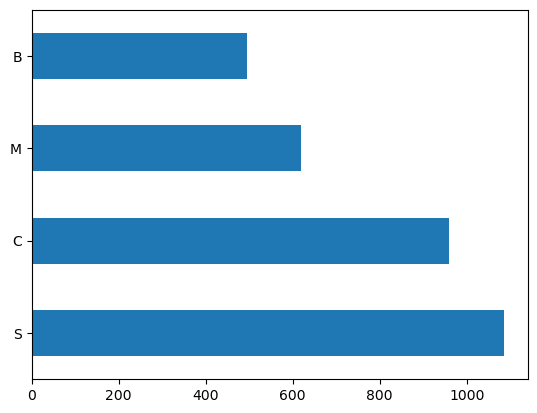

In [38]:
sub_metadata['center'].dropna().value_counts().plot(kind='barh')

## Co-occurence

In [39]:
convert_dict = {x: np.float64 for x in numeric_col}
sub_metadata_no_nan = sub_metadata.dropna()
sub_metadata_no_nan = sub_metadata_no_nan.astype(convert_dict)
sub_metadata_no_nan

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2
sample_name,,,,,,,,,,,,,
11666.G0001A,1.0,1.0,2.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0001L,1.0,1.0,2.0,1.0,0.0,1.0,0.0,F,4.0,4.0,M,0.0,1.0
11666.G0003A,1.0,1.0,1.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0003L,1.0,1.0,1.0,0.0,0.0,0.0,0.0,F,4.0,3.0,B,1.0,4.0
11666.G0004A,0.0,2.0,2.0,1.0,0.0,1.0,0.0,M,5.0,3.0,B,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11666.G1777A,0.0,2.0,1.0,1.0,0.0,1.0,1.0,M,3.0,3.0,C,1.0,4.0
11666.G1778A,1.0,2.0,2.0,1.0,1.0,1.0,0.0,F,6.0,3.0,S,0.0,3.0
11666.G1779A,1.0,1.0,3.0,1.0,0.0,1.0,0.0,F,5.0,3.0,S,0.0,2.0


### Converting diabetes and ckd into binary variables

In [40]:
diabetes_binary = {1.0:0.0,
                   2.0:0.0,
                   3.0:1.0}
ckd_binary = {1.0:0.0, 
              2.0:1.0,
              3.0:1.0,
              4.0:1.0,
              5.0:1.0}

In [41]:
sub_metadata_no_nan['diabetes2_v2'] = sub_metadata_no_nan['diabetes2_v2'].apply(lambda x: diabetes_binary[x])
sub_metadata_no_nan['ckd_v2'] = sub_metadata_no_nan['ckd_v2'].apply(lambda x:ckd_binary[x])

In [42]:
sub_metadata[['ckd_v2','abdominal_obesity_ncep_v2']].dropna().T.dot(sub_metadata[['ckd_v2','abdominal_obesity_ncep_v2']].dropna())

,ckd_v2,abdominal_obesity_ncep_v2
ckd_v2,8444.0,3291.0
abdominal_obesity_ncep_v2,3291.0,2180.0


<AxesSubplot:>

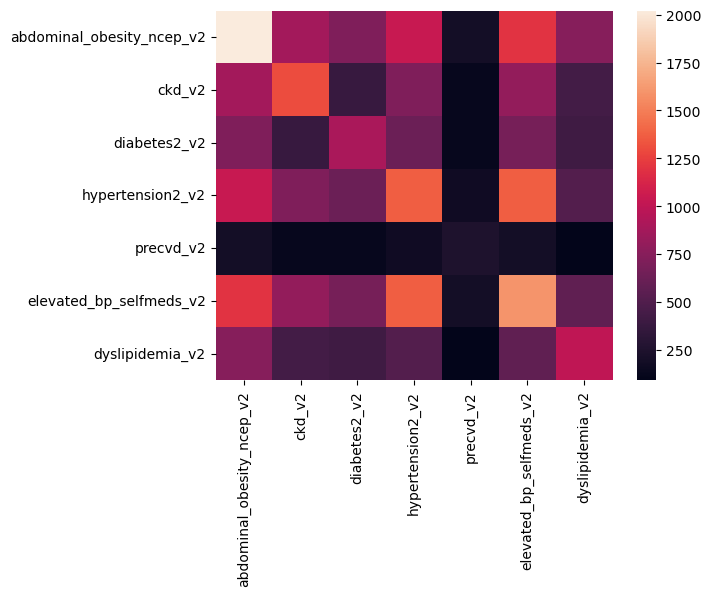

In [43]:
sns.heatmap(sub_metadata_no_nan[disease_cols].T.dot(sub_metadata_no_nan[disease_cols]))

### Num people who have multiple diseases

In [44]:
sub_metadata_no_nan['total_diseases'] = sub_metadata_no_nan[disease_cols].sum(axis=1)
sub_metadata_no_nan['total_diseases'].value_counts()

2.0    599
4.0    565
3.0    517
1.0    513
5.0    385
0.0    198
6.0    139
7.0     22
Name: total_diseases, dtype: int64

<AxesSubplot:>

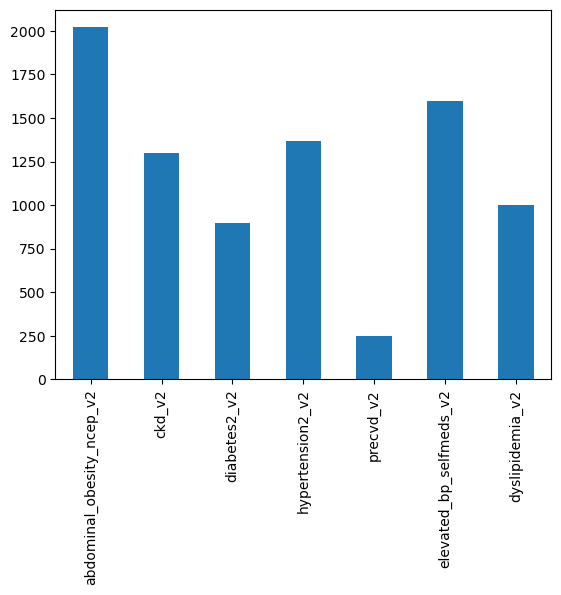

In [45]:
sub_metadata_no_nan[disease_cols].sum(axis=0).plot(kind='bar')

### Qiime metadata

convert df to qiime metadata

In [46]:
from qiime2 import Metadata

In [47]:
sub_metadata_no_nan.to_csv("data/temp/updated_metadata.tsv",sep="\t")
qiime_metadata = Metadata.load("data/temp/updated_metadata.tsv")
qiime_metadata.save('data/temp/qiime_metadata.qza')

'data/temp/qiime_metadata.qza'

### FILTERING

In [48]:
from qiime2.plugins.feature_table.methods import filter_samples

In [49]:
updated_feature_table = filter_samples(table, metadata = qiime_metadata).filtered_table
updated_feature_table

<artifact: FeatureTable[Frequency] uuid: 3a554831-3910-4842-bf5a-2cc45a41819f>

In [50]:
biom_table = updated_feature_table.view(biom.Table)
print(biom_table.head())

# Constructed from biom file
#OTU ID	11666.G0341A	11666.G0393A	11666.G0149A	11666.G0091A	11666.G0377A
AACATAAGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGCCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAAACACTGGGCGTAAAGGGCGCGTAGGCGGTCTGTTAAGTCGGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCATAAAGGGCGCGTAGGTGGTTTGTTAAGTCAGATGTGAAATGTAGGGGCTCAACCCCTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGAGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG	0.0	0.0	0.0	0.0	0.0


In [51]:
biom_table.ids()

array(['11666.G0341A', '11666.G0393A', '11666.G0149A', ...,
       '11666.G1685A', '11666.G1536A', '11666.G1519B'], dtype='<U12')

<AxesSubplot:>

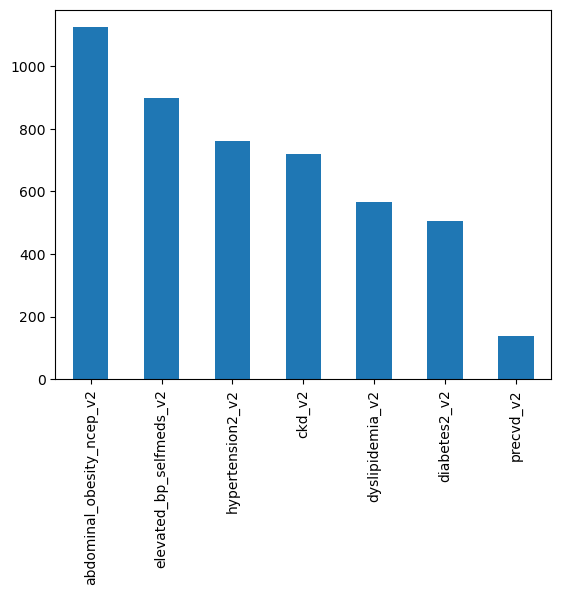

In [52]:
sub_metadata_no_nan.loc[biom_table.ids()][disease_cols].sum().sort_values(ascending=False).plot(kind='bar')

In [53]:
final_metadata = sub_metadata_no_nan.loc[biom_table.ids()]
final_metadata.head()

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2,gender_v2,agegroup_c6_v2,bmigrp_c6_v2,center,us_born_v2,income_c5_v2,total_diseases
sample_name,,,,,,,,,,,,,,
11666.G0341A,1.0,0.0,1.0,1.0,0.0,1.0,0.0,F,5.0,4.0,S,0.0,2.0,4.0
11666.G0393A,1.0,0.0,0.0,1.0,0.0,1.0,0.0,F,6.0,2.0,C,0.0,1.0,3.0
11666.G0149A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F,4.0,2.0,S,0.0,4.0,0.0
11666.G0091A,1.0,1.0,0.0,0.0,0.0,1.0,0.0,F,6.0,3.0,S,0.0,2.0,3.0
11666.G0377A,1.0,0.0,1.0,1.0,0.0,1.0,0.0,F,4.0,3.0,S,0.0,3.0,4.0


In [54]:
final_metadata['total_diseases'].value_counts()

2.0    331
4.0    314
3.0    294
1.0    287
5.0    212
0.0    114
6.0     80
7.0     12
Name: total_diseases, dtype: int64

<AxesSubplot:>

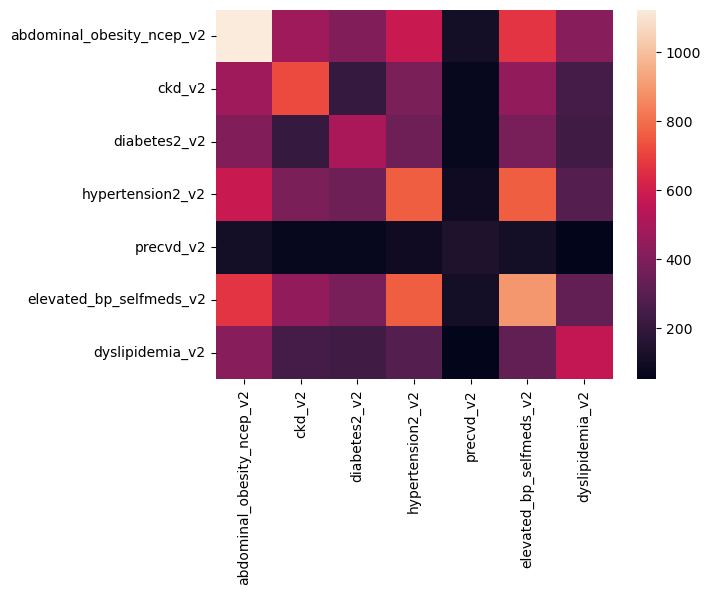

In [55]:
sns.heatmap(final_metadata[disease_cols].T.dot(final_metadata[disease_cols]))

### Distance Matrix

In [56]:
from qiime2.plugins.metadata.methods import distance_matrix

In [57]:
final_metadata[disease_cols].to_csv("data/temp/final_metadata.tsv",sep="\t")
final_qiime_metadata = Metadata.load("data/temp/final_metadata.tsv")

In [58]:
final_qiime_metadata

Metadata
--------
1644 IDs x 7 columns
abdominal_obesity_ncep_v2: ColumnProperties(type='numeric', missing_scheme='blank')
ckd_v2:                    ColumnProperties(type='numeric', missing_scheme='blank')
diabetes2_v2:              ColumnProperties(type='numeric', missing_scheme='blank')
hypertension2_v2:          ColumnProperties(type='numeric', missing_scheme='blank')
precvd_v2:                 ColumnProperties(type='numeric', missing_scheme='blank')
elevated_bp_selfmeds_v2:   ColumnProperties(type='numeric', missing_scheme='blank')
dyslipidemia_v2:           ColumnProperties(type='numeric', missing_scheme='blank')

Call to_dataframe() for a tabular representation.

In [59]:
distance_matrix_v2 = distance_matrix(final_qiime_metadata.get_column('ckd_v2')).distance_matrix

### Multi label Classification

In [60]:
from qiime2.plugins.sample_classifier.pipelines import classify_samples

In [61]:
import torch as t

In [62]:
labels_df = t.tensor(final_metadata[disease_cols].values)
labels_df

tensor([[1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]], dtype=torch.float64)

In [63]:
feature_matrix = t.tensor(table.view(pd.DataFrame).values)
feature_matrix

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [64]:
final_metadata[disease_cols]

,abdominal_obesity_ncep_v2,ckd_v2,diabetes2_v2,hypertension2_v2,precvd_v2,elevated_bp_selfmeds_v2,dyslipidemia_v2
sample_name,,,,,,,
11666.G0341A,1.0,0.0,1.0,1.0,0.0,1.0,0.0
11666.G0393A,1.0,0.0,0.0,1.0,0.0,1.0,0.0
11666.G0149A,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11666.G0091A,1.0,1.0,0.0,0.0,0.0,1.0,0.0
11666.G0377A,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
11666.G1518B,1.0,0.0,1.0,1.0,0.0,1.0,0.0
11666.G1501A,0.0,1.0,1.0,1.0,0.0,1.0,1.0
11666.G1685A,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Creation

In [65]:
def binary_to_tf(val):
    if val==1.0:
        return 'T'
    elif val==0.0:
        return 'F'
    else:
        return 'missing'

In [66]:
# sub_metadata_no_nan['abdominal_obesity_ncep_v2'] = sub_metadata_no_nan['abdominal_obesity_ncep_v2'].apply(lambda x: binary_to_tf(x))

In [67]:
# sub_metadata_no_nan

### model

In [68]:
classify_samples(table, qiime_metadata.get_column('abdominal_obesity_ncep_v2'), missing_samples='ignore')

TypeError: Parameter 'metadata' received <NumericMetadataColumn name='abdominal_obesity_ncep_v2' id_count=2938> as an argument, which is incompatible with parameter type: MetadataColumn[Categorical]